In [175]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import fnmatch
import logging
from os.path import join as pjoin
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import patheffects

from shapely.geometry import LineString
from shapely.geometry import box as sbox
import math

from vincenty import vincenty
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd

import scipy.stats as stats

from Utilities.metutils import convert
from Utilities.files import flStartLog


import matplotlib
import statsmodels.nonparametric.api as smnp

matplotlib.use('tkagg')
%matplotlib inline

sns.set_style('whitegrid')
sns.set_context('notebook', rc={"grid.linewidth": 0.5, "grid.linestyle": ':'})

In [2]:



def filter_tracks_domain(df, minlon=90, maxlon=180, minlat=-40, maxlat=0,
                         idcode='num', latname='lat', lonname='lon'):
    """
    Takes a `DataFrame` and filters on the basis of whether the track interscts
    the given domain, which is specified by the minimum and maximum longitude and
    latitude.
    NOTE: This assumes the tracks and bounding box are in the same geographic
    coordinate system (i.e. generally a latitude-longitude coordinate system).
    It will NOT support different projections (e.g. UTM data for the bounds and
    geographic for the tracks).
    NOTE: This doesn't work if there is only one point for the track.
    :param df: :class:`pandas.DataFrame` that holds the TCLV data
    :param float minlon: minimum longitude of the bounding box
    :param float minlat: minimum latitude of the bounding box
    :param float maxlon: maximum longitude of the bounding box
    :param float maxlat: maximum latitude of the bounding box
    """

    domain = sbox(minlon, minlat, maxlon, maxlat, ccw=False)
    tracks = df.groupby(idcode)
    tempfilter = tracks.filter(lambda x: len(x) > 1)
    filterdf = tempfilter.groupby(idcode).filter(lambda x: LineString(zip(x[lonname], x[latname])).intersects(domain))
    return filterdf

def convertLatLon(strval: str) -> float:
    """
    Convert a string representing lat/lon values from '140S to -14.0, etc.
    :param str strval: string containing the latitude or longitude.
    :returns: Latitude/longitude as a float value.
    """
    hemi = strval[-1].upper()
    fval = float(strval[:-1]) / 10.
    if (hemi == 'S') | (hemi == 'W'): 
        fval *= -1
    if (hemi == 'E') | (hemi == 'W'):
        fval = fval % 360
    return fval

def season(year: int, month: int) -> int:
    """
    Determine the southern hemisphere TC season based on the year and month value.
    If the month is earlier than June, we assign the season to be the preceding year.
    :params int year: Year
    :params int month: Month
    """
    s = year
    if month < 6:
        s = year - 1
    return int(s)



COLTYPES = ['|S2', 'i', datetime, 'i', '|S4', 'i', 'f', 'f', 'f', 'f',
            '|S4', 'f', '|S3', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f',
            '|S1', 'f', '|S3', 'f', 'f', '|S10', '|S1', 'f',
            '|S3', 'f', 'f', 'f', 'f']
COLUNITS = ['', '', '', '', '', '', '', '', 'kts', 'hPa',
            '', 'nm', '', 'nm', 'nm', 'nm', 'nm', 'hPa', 'nm', 'nm', 'kts', 'nm',
            '', '', '', 'degrees', 'kts', '', '', '',
            '', '', '', '', '']

DATEFORMAT = "%Y%m%d%H"
CONVERTERS = {
    'Number': lambda s: s.strip(' ,'),
    "Datetime": lambda s: datetime.strptime(s.strip(' ,'), DATEFORMAT),
    "Latitude": lambda s: float(convertLatLon(s.strip(' ,'))),
    "Longitude": lambda s: float(convertLatLon(s.strip(' ,'))),
    "Windspeed": lambda s: float(s.strip(' ,') or 0),
    "Pressure": lambda s: float(s.strip(' ,') or 0),
    "Status": lambda s: s.strip(' ,'),
    "RAD": lambda s: float(s.strip(' ,') or 0),
    "WINDCODE": lambda s: s.strip(' ,'),
    "RAD1": lambda s: convert(float(s.strip(' ,') or 0), COLUNITS[13], 'km'),
    "RAD2": lambda s: convert(float(s.strip(' ,') or 0), COLUNITS[14], 'km'),
    "RAD3": lambda s: convert(float(s.strip(' ,') or 0), COLUNITS[15], 'km'),
    "RAD4": lambda s: convert(float(s.strip(' ,') or 0), COLUNITS[16], 'km'),
    "Poci": lambda s: float(s.strip(' ,') or 0),
    "Roci": lambda s: convert(float(s.strip(' ,') or 0), COLUNITS[18], 'km'),
    "rMax": lambda s: convert(float(s.strip(' ,') or 0), COLUNITS[19], 'km'),
    "SPEED": lambda s: float(s.strip(' ,') or 0.0),
}


def loadFile(filename: str) -> pd.DataFrame:
    """
    Attempt to load a JTWC B-DECK format file. Older format files have fewer
    fields, so only require a subset of column names. If the full list of column
    names is used, a `ValueError` is raised when applying the converters.
    :param filename: Path to the file to load
    :returns: `pd.DataFrame` of the track contained in the file.
    """

    try:
        COLNAMES = ['BASIN','Number', 'Datetime', 'TECHNUM', 'TECH', 'TAU', 'Latitude', 'Longitude', 'Windspeed', 'Pressure',
            'Status', 'RAD', 'WINDCODE', 'RAD1', 'RAD2', 'RAD3', 'RAD4', 'Poci', 'Roci', 'rMax', 'GUSTS', 'EYE',
            'SUBREGION', 'MAXSEAS', 'INITIALS', 'DIR', 'SPEED', 'STORMNAME', 'DEPTH', 'SEAS',
            'SEASCODE', 'SEAS1', 'SEAS2', 'SEAS3', 'SEAS4']
        df = pd.read_csv(filename, names=COLNAMES, delimiter=",",
                         parse_dates=[2], infer_datetime_format=True,
                         skipinitialspace=True, converters=CONVERTERS,
                         error_bad_lines=False)
    except ValueError:
        try:
            COLNAMES = ['BASIN','Number', 'Datetime','TECHNUM', 'TECH', 'TAU',
                        'Latitude', 'Longitude', 'Windspeed','Pressure', '']
            df = pd.read_csv(filename, names=COLNAMES, delimiter=",",
                             parse_dates=[2], infer_datetime_format=True,
                             skipinitialspace=True, converters=CONVERTERS,
                             error_bad_lines=False)
        except ValueError:
            COLNAMES = ['BASIN','Number', 'Datetime','TECHNUM', 'TECH', 'TAU',
                        'Latitude', 'Longitude', 'Windspeed','Pressure', ]
            df = pd.read_csv(filename, names=COLNAMES, delimiter=",",
                             parse_dates=[2], infer_datetime_format=True,
                             skipinitialspace=True, converters=CONVERTERS,
                             usecols=range(10), error_bad_lines=False)

    return df

In [3]:
inputPath = "../data/jtwc"

alltracks = []
for file in os.listdir(inputPath):
    if fnmatch.fnmatch(file, "bsh*.txt") or fnmatch.fnmatch(file, "bsh*.dat"):
        tempdf = loadFile(pjoin(inputPath, file))
        tempdf['eventid'] = os.path.splitext(file)[0]
        alltracks.append(tempdf)

/var/folders/lw/g1x0fwqd4wjf3v9dvzzwq1m00000gn/T/ipykernel_8909/1213633650.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  tempdf = loadFile(pjoin(inputPath, file))


In [4]:
df = pd.concat(alltracks)

In [5]:
df['dP'] = df.Poci - df.Pressure
df = filter_tracks_domain(
    df, 90, 160, -40, 0, 'eventid', 'Latitude', 'Longitude'
)

filter_ = (df['Status'] == 'TS') | (df['Status'] == 'TY')
filter_ &= (df['rMax'] > 0.0)
filter_ &= (df['Poci'] > 0.0)
filter_ &= (df['dP'] > 0.0)

df = df[filter_].copy()

In [6]:
# df['dP'] = df.Poci - df.Pressure
# df = df[~np.isnan(df.rMax)]
# df = df[df.dP > 0]
# df = df[df.rMax > 0]

In [7]:

df['year'] = pd.DatetimeIndex(df['Datetime']).year
df['month'] = pd.DatetimeIndex(df['Datetime']).month
df['season'] = df[['year', 'month']].apply(lambda x: season(*x), axis=1)
df['beta'] = (0.514444 * df.Windspeed) ** 2
df['beta'] *= 1.15 * np.exp(1) / (df.dP * 100)

In [8]:
rads = [f"RAD{i}" for i in range(1, 5)]
mask = (df.RAD > 0) & (df[rads].values.min(axis=1) > 0)

df['r34'] = df[rads].values.mean(axis=1)
df['r34'].values[~mask] = np.nan

In [9]:
df.drop_duplicates(['eventid', 'Datetime'], inplace=True)

In [10]:
df.sort_values(by=['eventid', 'Datetime'], inplace=True)
df.reset_index(inplace=True, drop=True)
df['new_index'] = np.arange(len(df))
event_ids = pd.unique(df.eventid)

idxs = df.groupby(['eventid']).agg({'new_index': np.min}).values
df.drop('new_index', axis=1, inplace=True)

dt = np.diff(df.Datetime) / (3600 * np.timedelta64(1, 's')) # in hours
coords = df[["Latitude", "Longitude"]].values
dists = [vincenty(coords[i], coords[i + 1]) for i in range(len(coords) - 1)]
speed = np.zeros(len(df))
speed[1:] = np.array(dists) / dt
speed[idxs] = 0
df['translation_speed'] = speed

In [11]:
xc = df.groupby(['eventid',]).agg({
    'Pressure': np.min,
    'Windspeed': np.max,
    'season': 'max',
    'rMax': np.max,
    'SPEED': np.max,
    'dP': np.max,
    'eventid':'first'}
)
ns = xc[xc['Windspeed'] > 64]

## All TCs - all datapoints stats

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


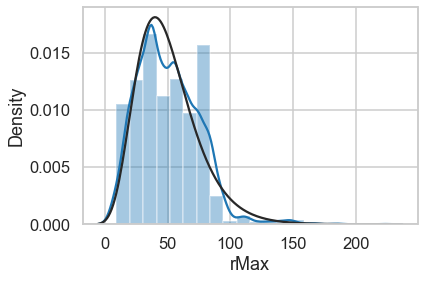

In [12]:
sns.distplot(df.rMax, fit=stats.lognorm, bins=20)
plt.show()

In [168]:
use_cols = [
    'rMax', 'dP', 'Windspeed', 'Latitude', 'translation_speed',
    'RAD1', 'RAD2', 'RAD3', 'RAD4', 'Roci', 'r34'
]

tmp_df = df[use_cols].copy()
tmp_df['RAD1'].values[(df['RAD'].values == 0) | (df['RAD1'].values == 0)] = np.nan
tmp_df['RAD2'].values[(df['RAD'].values == 0) | (df['RAD2'].values == 0)] = np.nan
tmp_df['RAD3'].values[(df['RAD'].values == 0) | (df['RAD3'].values == 0)] = np.nan
tmp_df['RAD4'].values[(df['RAD'].values == 0) | (df['RAD4'].values == 0)] = np.nan

corr = tmp_df.corr()
corr.values[:] = np.round(corr.values, 3)
corr

,rMax,dP,Windspeed,Latitude,translation_speed,RAD1,RAD2,RAD3,RAD4,Roci,r34
rMax,1.000,-0.617,-0.647,0.077,-0.117,-0.083,-0.118,-0.118,-0.086,0.002,-0.123
dP,-0.617,1.000,0.975,-0.110,0.123,0.400,0.402,0.414,0.390,0.140,0.440
Windspeed,-0.647,0.975,1.000,-0.141,0.151,0.465,0.451,0.457,0.445,0.152,0.498
Latitude,0.077,-0.110,-0.141,1.000,-0.420,-0.309,-0.355,-0.272,-0.206,-0.193,-0.318
translation_speed,-0.117,0.123,0.151,-0.420,1.000,0.222,0.198,0.141,0.125,0.079,0.190
RAD1,-0.083,0.400,0.465,-0.309,0.222,1.000,0.782,0.748,0.868,0.358,0.923
RAD2,-0.118,0.402,0.451,-0.355,0.198,0.782,1.000,0.897,0.683,0.331,0.923
RAD3,-0.118,0.414,0.457,-0.272,0.141,0.748,0.897,1.000,0.761,0.317,0.930
RAD4,-0.086,0.390,0.445,-0.206,0.125,0.868,0.683,0.761,1.000,0.329,0.896
Roci,0.002,0.140,0.152,-0.193,0.079,0.358,0.331,0.317,0.329,1.000,0.361


/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


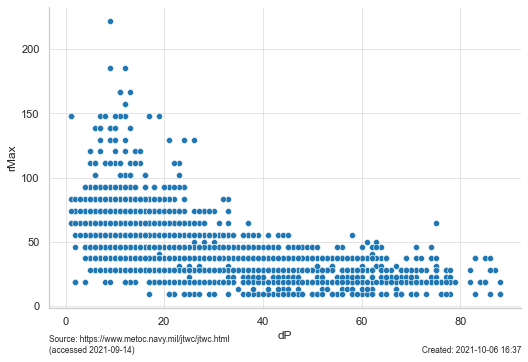

In [179]:
fct = sns.relplot(df.dP, df.rMax, height=5, aspect=1.5)
plt.text(0.0, -0.15, "Source: https://www.metoc.navy.mil/jtwc/jtwc.html \n(accessed 2021-09-14)", 
          transform=fct.ax.transAxes, fontsize='x-small', ha='left',)
plt.text(1.0, -0.15, f"Created: {datetime.now():%Y-%m-%d %H:%M}",
         transform=fct.ax.transAxes, fontsize='x-small', ha='right')
plt.show()

In [169]:
# fct = sns.relplot(df.Windspeed, df.rMax, aspect=1.5)
# fct.ax.text(50.0, -50, "Source: https://www.metoc.navy.mil/jtwc/jtwc.html \n(accessed 2021-09-14)", fontsize='xx-small', ha='left',)
# fct.ax.text(20.0, -50, f"Created: {datetime.now():%Y-%m-%d %H:%M}", fontsize='xx-small', ha='right')
# plt.show()

In [170]:
# mask = df.Windspeed > 34 # max windspeed > 34 knots
# ax = sns.relplot(df.dP[mask], df.Windspeed[mask], aspect=1.5)
# plt.text(0.0, -0.1, "Source: https://www.metoc.navy.mil/jtwc/jtwc.html \n(accessed 2021-09-14)",
#          transform=ax.transAxes, fontsize='xx-small', ha='left',)
# plt.text(1.0, -0.1, f"Created: {datetime.now():%Y-%m-%d %H:%M}",
#          transform=ax.transAxes, fontsize='xx-small', ha='right')
# plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


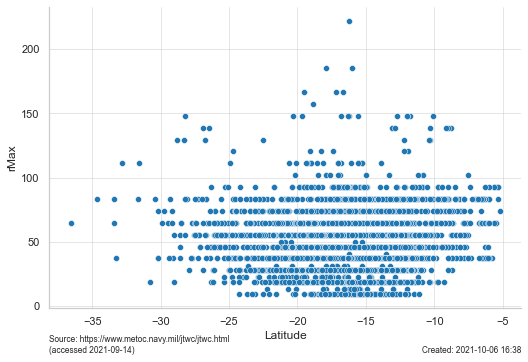

In [181]:
fct = sns.relplot(df.Latitude, df.rMax, aspect=1.5)
plt.text(0.0, -0.15, "Source: https://www.metoc.navy.mil/jtwc/jtwc.html \n(accessed 2021-09-14)", 
          transform=fct.ax.transAxes, fontsize='x-small', ha='left',)
plt.text(1.0, -0.15, f"Created: {datetime.now():%Y-%m-%d %H:%M}",
         transform=fct.ax.transAxes, fontsize='x-small', ha='right')
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


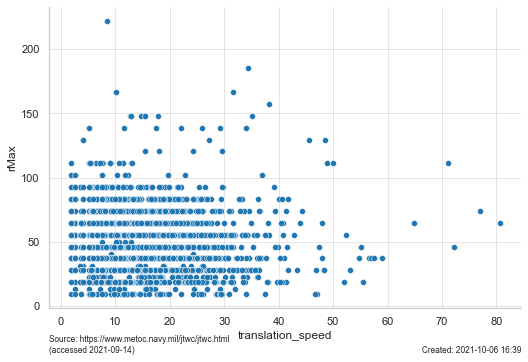

In [183]:
mask = df.translation_speed > 0
fct = sns.relplot(df.translation_speed[mask], df.rMax[mask], aspect=1.5)
plt.text(0.0, -0.15, "Source: https://www.metoc.navy.mil/jtwc/jtwc.html \n(accessed 2021-09-14)", 
          transform=fct.ax.transAxes, fontsize='x-small', ha='left',)
plt.text(1.0, -0.15, f"Created: {datetime.now():%Y-%m-%d %H:%M}",
         transform=fct.ax.transAxes, fontsize='x-small', ha='right')
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


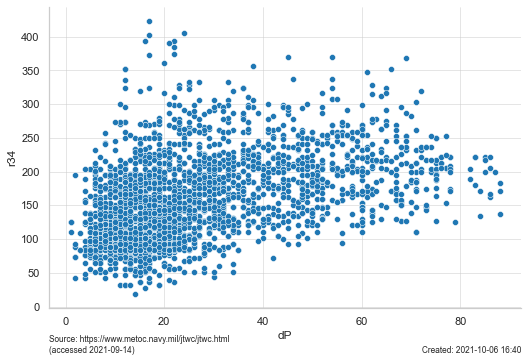

In [185]:
fct = sns.relplot(df.dP, df.r34, height=5, aspect=1.5)
plt.text(0.0, -0.15, "Source: https://www.metoc.navy.mil/jtwc/jtwc.html \n(accessed 2021-09-14)", 
          transform=fct.ax.transAxes, fontsize='x-small', ha='left',)
plt.text(1.0, -0.15, f"Created: {datetime.now():%Y-%m-%d %H:%M}",
         transform=fct.ax.transAxes, fontsize='x-small', ha='right')
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


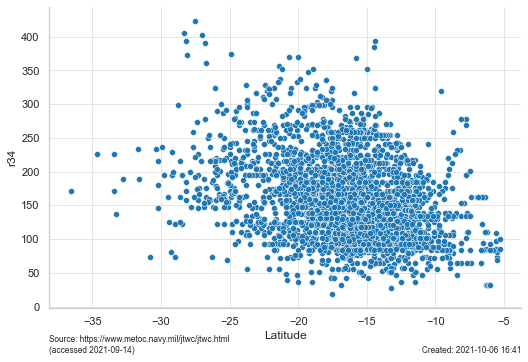

In [186]:
fct = sns.relplot(df.Latitude, df.r34, aspect=1.5)
plt.text(0.0, -0.15, "Source: https://www.metoc.navy.mil/jtwc/jtwc.html \n(accessed 2021-09-14)", 
          transform=fct.ax.transAxes, fontsize='x-small', ha='left',)
plt.text(1.0, -0.15, f"Created: {datetime.now():%Y-%m-%d %H:%M}",
         transform=fct.ax.transAxes, fontsize='x-small', ha='right')
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


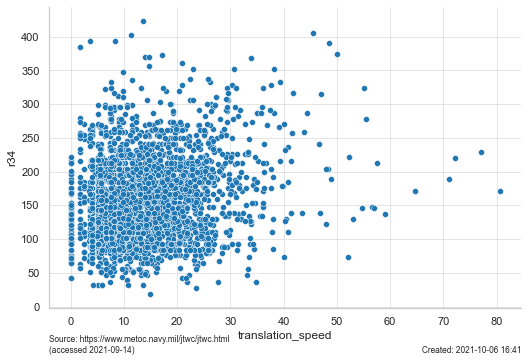

In [187]:
fct = sns.relplot(df.translation_speed, df.r34, aspect=1.5)
plt.text(0.0, -0.15, "Source: https://www.metoc.navy.mil/jtwc/jtwc.html \n(accessed 2021-09-14)", 
          transform=fct.ax.transAxes, fontsize='x-small', ha='left',)
plt.text(1.0, -0.15, f"Created: {datetime.now():%Y-%m-%d %H:%M}",
         transform=fct.ax.transAxes, fontsize='x-small', ha='right')
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


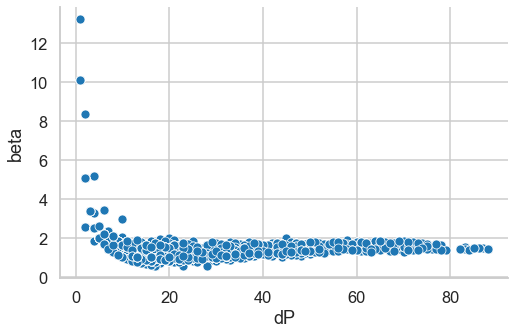

In [20]:
mask = df.Windspeed >= 0
sns.relplot(df.dP[mask], df.beta[mask], aspect=1.5)
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


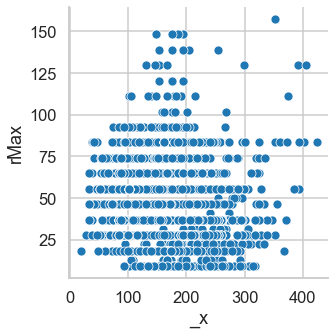

In [21]:
rads = [f"RAD{i}" for i in range(1, 5)]
mask = (df.RAD > 0) & (df[rads].values.min(axis=1) > 0)

r34 = df[mask][rads].values.mean(axis=1)

sns.relplot(r34, df.rMax[mask], aspect=1)
plt.show()

[[ 1.         -0.12326466]
 [-0.12326466  1.        ]]


/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


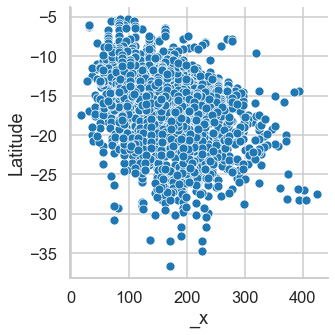

In [22]:
rads = [f"RAD{i}" for i in range(1, 5)]
mask = (df.RAD > 0) & (df[rads].values.min(axis=1) > 0)

r34 = df[mask][rads].values.mean(axis=1)

print(np.corrcoef(r34, df.rMax[mask]))

sns.relplot(r34, df.Latitude[mask], aspect=1)
plt.show()

[[ 1.         -0.12326466]
 [-0.12326466  1.        ]]


/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


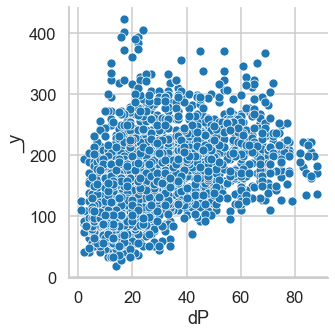

In [23]:
rads = [f"RAD{i}" for i in range(1, 5)]
mask = (df.RAD > 0) & (df[rads].values.min(axis=1) > 0)
r34 = df[mask][rads].values.mean(axis=1)
print(np.corrcoef(r34, df.rMax[mask]))
sns.relplot(df.dP[mask], r34, aspect=1)
plt.show()

[[ 1.         -0.08272992]
 [-0.08272992  1.        ]]


/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


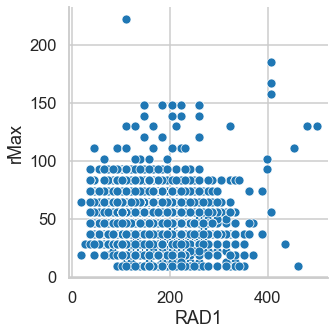

In [24]:
mask = (df.RAD > 0) & (df.RAD1 > 0)

sns.relplot(df[mask].RAD1, df.rMax[mask], aspect=1)
print(np.corrcoef((df[mask].RAD1, df.rMax[mask])))
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


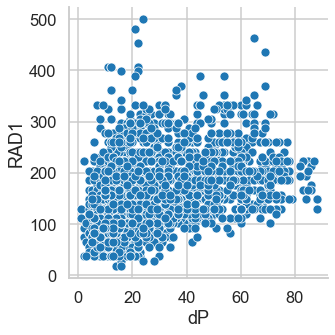

In [25]:
mask = (df.RAD > 0) & (df.RAD1 > 0)

sns.relplot(df[mask].dP, df[mask].RAD1, aspect=1)
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


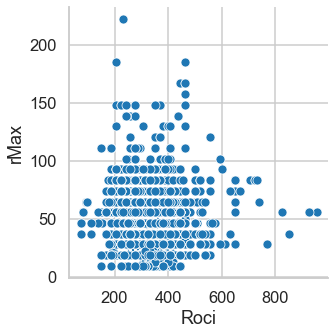

In [26]:
mask = (df.Roci > 0)
sns.relplot(df[mask].Roci, df.rMax[mask], aspect=1)
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


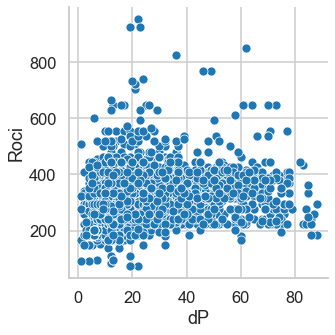

In [27]:
mask = (df.Roci > 0)

sns.relplot(df[mask].dP, df[mask].Roci, aspect=1)
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


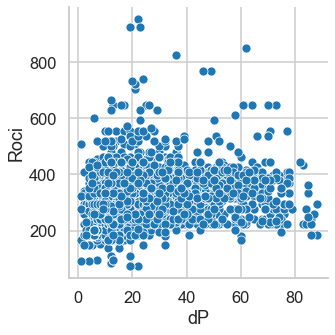

In [28]:

sns.relplot(df[mask].dP, df[mask].Roci, aspect=1)
plt.show()

## Evaluation of Fit of Beta

In [29]:
from scipy.optimize import least_squares

134.3730800988942
Max predicted value: 134.3730800988942
Max observed value: 125.0
R-squared: 0.9157510696744464
Residual average for severe TCs: -1.2772690559473967


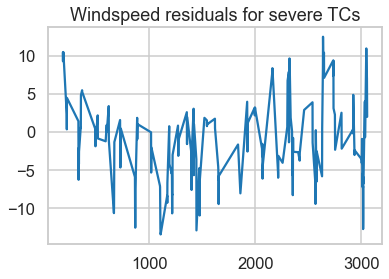

In [30]:
beta_pred = 1.881093 - 0.010917 * np.abs(df.Latitude) - 0.005561 * df.rMax
windspeed_pred = np.sqrt(df.dP * 100 * beta_pred / (1.15 * np.exp(1))) / 0.514444
print(windspeed_pred.max())

Rsqr = 1 - np.mean((windspeed_pred - df.Windspeed) ** 2) / np.var(df.Windspeed)

mask = df.Windspeed > 100
print("Max predicted value:", windspeed_pred.max())
print("Max observed value:", df.Windspeed.max())
print("R-squared:", Rsqr)
print("Residual average for severe TCs:", (windspeed_pred[mask] - df.Windspeed[mask]).mean())

plt.title("Windspeed residuals for severe TCs")
plt.plot(windspeed_pred[mask] - df.Windspeed[mask])
plt.show()

Max predicted value: 119.86365465520993
Max observed value: 125.0
R-squared: 0.9253685063142173
Residual average for severe TCs: -9.273801121405128


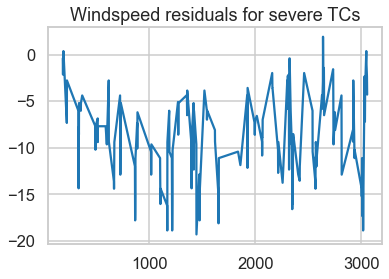

In [31]:
from sklearn.linear_model import LinearRegression

xs = np.sqrt(df.dP * 100 / (1.15 * np.exp(1))) / 0.514444
beta_fixed = ((df.Windspeed * xs).sum() / (xs ** 2).sum()) ** 2

windspeed_pred = beta_fixed * xs

windspeed_pred = np.sqrt(df.dP * 100 * beta_fixed / (1.15 * np.exp(1))) / 0.514444

Rsqr = 1 - np.mean((windspeed_pred - df.Windspeed) ** 2) / np.var(df.Windspeed)

mask = df.Windspeed > 100
print("Max predicted value:", windspeed_pred.max())
print("Max observed value:", df.Windspeed.max())
print("R-squared:", Rsqr)
print("Residual average for severe TCs:", (windspeed_pred[mask] - df.Windspeed[mask]).mean())


plt.title("Windspeed residuals for severe TCs")
plt.plot(windspeed_pred[mask] - df.Windspeed[mask])
plt.show()

Beta coefficients [ 1.48378487 -0.00825403 -0.00615678]
Max predicted value: 127.56909113997753
Max observed value: 125.0
R-squared: 0.9338382660996228
Residual average for severe TCs: -4.433528092440167


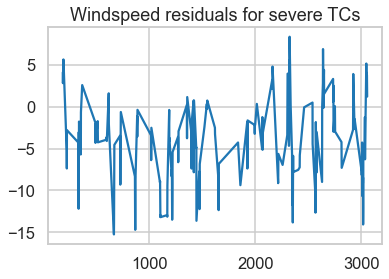

In [32]:
import cvxpy as cp

e_const = np.exp(1)
x = cp.Variable(3)
mat = np.ones((3, len(df)))
mat[1:] = df.Latitude
mat[2:] = df.rMax

const = 100 / (1.15 * e_const * 0.514444 ** 2)

loss = cp.sum_squares(cp.multiply(cp.matmul(x, mat), df.dP) * const - df.Windspeed ** 2)
objective = cp.Minimize(loss)
# constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective)
result = prob.solve()

print("Beta coefficients", x.value)

beta_pred = x.value[0] + x.value[1] * df.Latitude + x.value[2] * df.rMax
windspeed_pred = np.sqrt(df.dP * 100 * beta_pred / (1.15 * np.exp(1))) / 0.514444
Rsqr = 1 - np.mean((windspeed_pred - df.Windspeed) ** 2) / np.var(df.Windspeed)

mask = df.Windspeed > 100
print("Max predicted value:", windspeed_pred.max())
print("Max observed value:", df.Windspeed.max())
print("R-squared:", Rsqr)
print("Residual average for severe TCs:", (windspeed_pred[mask] - df.Windspeed[mask]).mean())


plt.title("Windspeed residuals for severe TCs")
plt.plot(windspeed_pred[mask] - df.Windspeed[mask])
plt.show()

## Evaluation of Fit of Rmax

In [215]:
import tensorflow as tf
from Utilities.metutils import convert

import numpy as np
np.random.seed(1)
import scipy.stats as stats

import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.nonparametric.api as smnp
from six import string_types

from statsmodels.distributions.empirical_distribution import ECDF

from lmfit import Model, Minimizer, fit_report, conf_interval, printfuncs, report_fit
import corner

In [38]:
dP = tf.constant(df.dP.values.astype(np.float32))
lat = tf.constant(df.Latitude.values.astype(np.float32))
rlog = tf.constant(np.log(df.rMax.values.astype(np.float32)))
rMax = df.rMax.values.astype(np.float32)

@tf.function
def loss(params):
    
    exp = tf.exp(params[3] * dP ** 2)
    pred = params[0] + params[1] * dP + params[4] * lat ** 2 + params[2] * exp
    
    # return tf.math.reduce_sum((tf.exp(pred) - rMax) ** 2)
    return tf.math.reduce_sum((pred - rlog) ** 2)

# params = tf.Variable([3.543, -0.003, 0.813, -0.0022, 0.0015])
# for _ in range(100):
#     with tf.GradientTape() as tape:
#         y = loss(params)
#         dydp = tape.gradient(y, params)
#         print(dydp)
#         break
#         step = -0.000000001 * dydp
#         params.assign_add(step)
# params
# print(np.round(params.numpy(), 5))

In [75]:
params = tf.Variable([3.543, -0.00378, 0.813, -0.0022, 0.00157])
for _ in range(1):
    with tf.GradientTape() as t2:
        with tf.GradientTape() as t1:
            y = loss(params)

            g = t1.gradient(y, params)

        h = t2.jacobian(g, params)
        step = -0.1 * tf.linalg.matvec(tf.linalg.inv(h), g)
        params.assign_add(step)

np.linalg.norm(g.numpy())

# 1087306.9
# 3.2056892

3.2056892

In [107]:
import scipy
def np_loss(params):
    exp = np.exp(params[3] * dP ** 2)
    pred = params[0] + params[1] * dP + params[4] * lat ** 2 + params[2] * exp
    
    # return tf.math.reduce_sum((tf.exp(pred) - rMax) ** 2)
    return np.sum((pred - rlog) ** 2)

point = np.array([3.543, -0.00378, 0.813, -0.0022, 0.00157])
print(np.linalg.norm(scipy.optimize._numdiff.approx_derivative(np_loss, point)))

point = np.array([4.2719436e+00, -2.0491846e-02,  9.8919329e-38, -3.6666862e-04, 7.0372378e-05])
print(np.linalg.norm(scipy.optimize._numdiff.approx_derivative(np_loss, point)))

5.777170454932273e+20
3.2848760031219686


In [194]:
# params = tf.Variable([ 4.2719436e+00, -2.0491846e-02,  9.8919329e-38, -3.6666862e-04, 7.0372378e-05])

# 40 * 7.0372378e-05
np.exp(40 ** 2 * 7.0372378e-05)

1.1191794745424395

RMSE 19.143154
Log space RMSE: 0.39568934
Reduced chi-squared: 1.001604699660021


/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


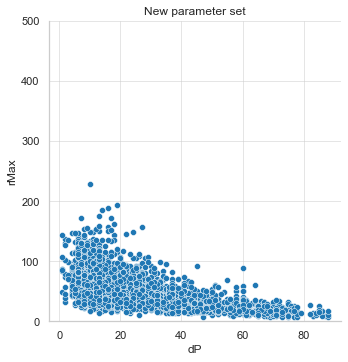

In [206]:
exp = tf.exp(params[3] * dP ** 2)
pred = (params[0] + params[1] * dP + params[4] * lat ** 2 + params[2] * exp).numpy()

residuals = (np.exp(pred) - rMax)
log_residuals = (pred - rlog.numpy())
noise_term = np.var(log_residuals)
reduced_chi_squared = (log_residuals ** 2 / noise_term).sum() / (len(log_residuals) - len(params.numpy()))

print("RMSE", np.sqrt((residuals ** 2).mean()))
print("Log space RMSE:", np.sqrt((log_residuals ** 2).mean()))
print("Reduced chi-squared:", reduced_chi_squared)

noise = np.random.normal(loc=0, size=len(df), scale=np.sqrt(noise_term))

a = sns.relplot(df.dP, np.exp(pred + noise))
a.set(title='New parameter set')
a.set(ylabel='rMax')
a.set(ylim=(0, 500))
plt.show()

RMSE 41.13684
Log space RMSE: 0.6547847
Reduced chi-squared: 2.1091277253490053


/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


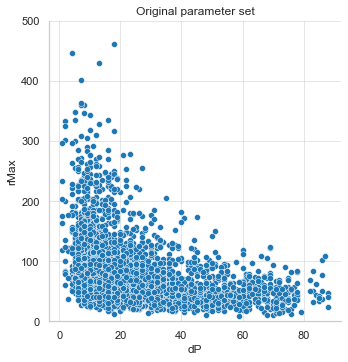

In [212]:
# 3.543−0.00378Δp+0.813exp(−0.0022Δp2)+0.00157λ2+ε

exp = tf.exp(-0.0022 * dP ** 2)
pred = (3.543 - 0.00378 * dP + 0.813 * exp + 0.00157 * lat ** 2).numpy()

residuals = (np.exp(pred) - rMax)
log_residuals = (pred - rlog.numpy())
noise_term = np.var(log_residuals)
reduced_chi_squared = (log_residuals ** 2 / noise_term).sum() / (len(log_residuals) - len(params.numpy()))

print("RMSE", np.sqrt((residuals ** 2).mean()))
print("Log space RMSE:", np.sqrt((log_residuals ** 2).mean()))
print("Reduced chi-squared:", reduced_chi_squared)

noise = np.random.normal(loc=0, size=len(df), scale=np.sqrt(noise_term))
a = sns.relplot(df.dP, np.exp(pred + noise))
a.set(title='Original parameter set')
a.set(ylim=(0, 500))
a.set(ylabel='rMax')
plt.show()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


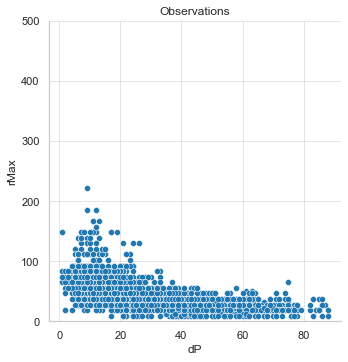

In [207]:
a = sns.relplot(df.dP, df.rMax)
a.set(ylim=(0, 500))
a.set(title='Observations')
plt.show()

## EMCEE

In [217]:
from statsmodels.distributions.empirical_distribution import ECDF
from lmfit import Model, Minimizer, fit_report, conf_interval, printfuncs, report_fit
import statsmodels.api as sm
from six import string_types
from seaborn.utils import _kde_support


In [218]:
rmax = df['rMax']
prs = df['Pressure']
poci = df['Poci']
lat = df['Latitude']

Parameter estimates:       Shape; Location (fixed);    Scale;    Mean
Southern hemisphere basin:  0.5385325872936041 0.0 44.23042613989218 50.36300672861263


/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


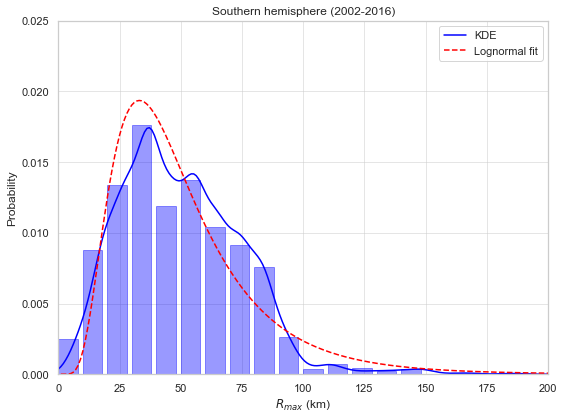

In [219]:
print("Parameter estimates:       Shape; Location (fixed);    Scale;    Mean")
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.distplot(rmax, bins=np.arange(0, 201, 10), hist_kws={'ec':'b', 'width':8},
             kde_kws={'clip':(0, 200), 'label':"KDE", 'color':'b'}, color='b', ax=ax)

shape, loc, scale = stats.lognorm.fit(rmax, scale=np.mean(rmax), floc=0)
print("Southern hemisphere basin: ", shape, loc, scale, np.mean(rmax))
x = np.arange(1, 201)
v = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)
fcdf = stats.lognorm.cdf(np.sort(rmax), shape, loc=loc, scale=scale)

ax.plot(x, v, color='r', linestyle='--', label="Lognormal fit")
ax.legend(loc=0)
ax.set_xlabel(r'$R_{max}$ (km)')
ax.set_ylabel('Probability')
ax.set_xlim((0, 200))
ax.set_ylim((0, 0.025))
ax.set_title("Southern hemisphere (2002-2016)")


fig.tight_layout()
#sns.despine()

Text(10, 0.9, '$R^{2}$ = 0.879353')

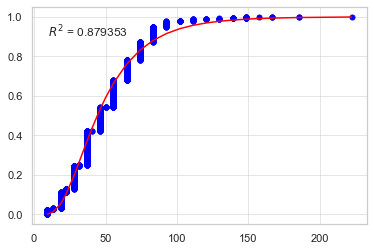

In [220]:
ecdf = ECDF(rmax, side='left')

plt.plot(np.sort(rmax), ecdf.y[1:], 'o', markersize=5, c='b')
plt.plot(np.sort(rmax), fcdf, 'r' )
rsq = stats.pearsonr(np.sort(rmax), fcdf)[0]**2
plt.text( 10, 0.9, r"$R^{2}$ = %f"%rsq)

In [221]:
def filterPoci(field, poci):
    filter1 = (poci >= 0.1)
    return field[filter1]


rmax = filterPoci(rmax, poci)
dp = filterPoci(poci, poci) - filterPoci(prs, poci)
dp = dp[rmax > 0]
dpsq = dp * dp
expdp = np.exp(-dp)
expdpsq = np.exp(-dpsq)
lat = filterPoci(lat, poci)
lat = lat[rmax > 0]
rmax = rmax[rmax > 0]

latsq = lat * lat

In [222]:
X = np.column_stack((dp, lat))
y = np.log(rmax.values)

In [223]:
def exp_dpsq(x, gamma, delta):
    dp = x[:, 0]
    return gamma * np.exp(-delta * dp * dp)


def lin_dp(x, alpha, beta):
    dp = x[:, 0]
    return alpha + beta * dp


def lin_lat(x, zeta):
    lat = np.abs(x[:, 1])
    return zeta * lat

In [233]:
# rmod = Model(lin_dp) + Model(exp_dpsq) + Model(lin_lat)
# params = rmod.make_params(alpha=1., beta=-0.001,
#                           gamma=.1, delta=.001, zeta=.001)


# def resid(p):
#     return p['alpha'] + p['beta'] * X[:, 0] + p['gamma'] * np.exp(-p['delta'] * X[:, 0] * X[:, 0]) + p['zeta'] * np.abs(X[:, 1]) - y


# mini = Minimizer(resid, params)
# result = mini.minimize()
# print(fit_report(result.params))
# ci = conf_interval(mini, result)
# printfuncs.report_ci(ci)
rmod = Model(lin_dp) + Model(lin_lat)
params = rmod.make_params(alpha=1., beta=-0.001, zeta=.001)


def resid(p):
    return p['alpha'] + p['beta'] * X[:, 0] + p['zeta'] * np.abs(X[:, 1]) - y


mini = Minimizer(resid, params)
result = mini.minimize()
print(fit_report(result.params))
ci = conf_interval(mini, result)
printfuncs.report_ci(ci)
print(result.chisqr) # 489 vs 488

[[Variables]]
    alpha:  4.28318688 +/- 0.02834167 (0.66%) (init = 1)
    beta:  -0.02045838 +/- 3.9936e-04 (1.95%) (init = -0.001)
    zeta:   4.9602e-04 +/- 0.00163419 (329.46%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, zeta) = -0.905
    C(alpha, beta) = -0.242
    C(beta, zeta)  = -0.110
          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 alpha:  -0.08512  -0.05675  -0.02835   4.28319  +0.02835  +0.05675  +0.08512
 beta :  -0.00120  -0.00080  -0.00040  -0.02046  +0.00040  +0.00080  +0.00120
 zeta :  -0.00491  -0.00327  -0.00163   0.00050  +0.00163  +0.00327  +0.00491
489.0089008187359


In [234]:
rr = mini.emcee(burn=500, steps=10_000)

100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 285.72it/s]


/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/corner/core.py:675: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/corner/core.py:675: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/corner/core.py:675: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


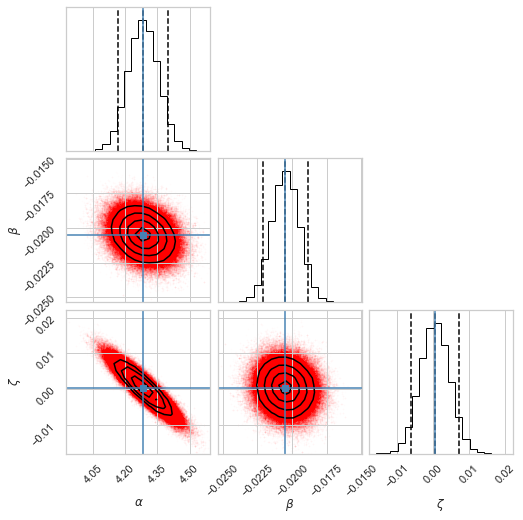

In [235]:
import corner
ll = [r'$\{0}$'.format(v) for v in rr.var_names]
with sns.plotting_context("notebook"):
    corner.corner(rr.flatchain, labels=ll, truths=list(rr.params.valuesdict().values()),
              no_fill_contours=True, fill_contours=False, plot_density=False,
              quantiles=[0.05, 0.5, 0.95],
                 data_kwargs=dict(color='r', alpha=0.01),
             contour_kwargs=dict(color='g'))

In [237]:
print(report_fit(rr.params))

[[Variables]]
    alpha:  4.28310342 +/- 0.07159883 (1.67%) (init = 4.283187)
    beta:  -0.02047240 +/- 0.00100664 (4.92%) (init = -0.02045838)
    zeta:   5.0743e-04 +/- 0.00411458 (810.87%) (init = 0.0004960151)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, zeta) = -0.905
    C(alpha, beta) = -0.245
    C(beta, zeta)  = -0.107
None


In [238]:
rr.params

name,value,standard error,relative error,initial value,min,max,vary
alpha,4.28310342,0.07159883,(1.67%),4.283186875254568,-inf,inf,True
beta,-0.02047240,0.00100664,(4.92%),-0.020458382735714473,-inf,inf,True
zeta,5.0743e-04,0.00411458,(810.87%),0.0004960151327485532,-inf,inf,True


In [239]:
result = rmod.fit(y, x=X, params=params)
print(result.fit_report())

[[Model]]
    (Model(lin_dp) + Model(lin_lat))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 3121
    # variables        = 3
    chi-square         = 489.008901
    reduced chi-square = 0.15683416
    Akaike info crit   = -5778.86105
    Bayesian info crit = -5760.72332
[[Variables]]
    alpha:  4.28318688 +/- 0.02834167 (0.66%) (init = 1)
    beta:  -0.02045838 +/- 3.9936e-04 (1.95%) (init = -0.001)
    zeta:   4.9602e-04 +/- 0.00163419 (329.46%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, zeta) = -0.905
    C(alpha, beta) = -0.242
    C(beta, zeta)  = -0.110


[[Model]]
    ((Model(lin_dp) + Model(exp_dpsq)) + Model(lin_lat))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 3121
    # variables        = 5
    chi-square         = 460.872421
    reduced chi-square = 0.14790514
    Akaike info crit   = -5959.80973
    Bayesian info crit = -5929.58019
[[Variables]]
    alpha:  3.27791291 +/- 0.13803387 (4.21%) (init = 1)
    beta:  -0.00374888 +/- 0.00206694 (55.13%) (init = -0.001)
    gamma:  0.96591343 +/- 0.11764598 (12.18%) (init = 0.1)
    delta:  0.00117845 +/- 1.2357e-04 (10.49%) (init = 0.001)
    zeta:   0.00312365 +/- 0.00159843 (51.17%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.982
    C(alpha, gamma) = -0.978
    C(alpha, beta)  = -0.969
    C(alpha, delta) =  0.825
    C(gamma, delta) = -0.803
    C(beta, delta)  = -0.788

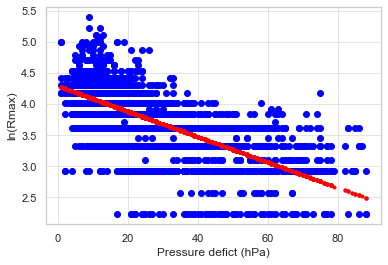

In [240]:
result.params = rr.params
plt.plot(X[:,0], y,         'bo')
#plt.plot(X[:,0], result.init_fit, 'k--')
plt.plot(X[:,0], result.best_fit, 'r.')
plt.xlabel("Pressure defict (hPa)")
plt.ylabel("ln(Rmax)")
plt.show()

In [241]:
comps = result.eval_components()
print(comps)


OrderedDict([('lin_dp', array([4.07837938, 4.03743457, 3.83271053, ..., 4.07837938, 4.09885178,
       4.09885178])), ('lin_lat', array([0.00375497, 0.00436388, 0.00466834, ..., 0.00517577, 0.00542948,
       0.00573394]))])


In [242]:
stats.normaltest(result.residual)


NormaltestResult(statistic=274.5641525116149, pvalue=2.3941525426383125e-60)

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


(2.996291465799706e-08, 0.39583254416212105)
NormaltestResult(statistic=274.5641525116149, pvalue=2.3941525426383125e-60)


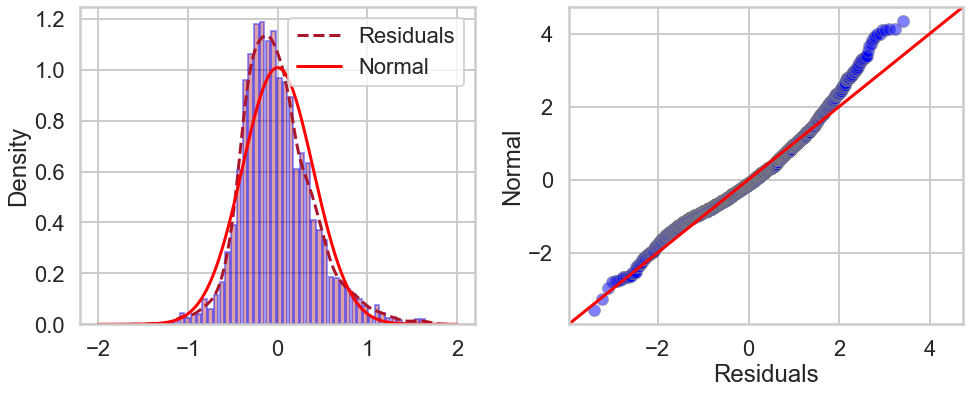

In [249]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,6))

ax = sns.distplot(result.residual, 
                  hist_kws={'ec':'b', 'width':0.05},
                  kde_kws={'label': 'Residuals', 'linestyle': '--'}, 
                  ax=ax0, norm_hist=True)
pp = sm.ProbPlot(result.residual, stats.norm, fit=True)
pp.qqplot('Residuals', 'Normal', line='45', ax=ax1, color='gray', alpha=0.5)
fig.tight_layout()
x = np.linspace(-2, 2, 1000)

ax0.legend(loc=0)

fp = stats.norm.fit(result.residual)
ax0.plot(x, stats.norm.pdf(x, fp[0], fp[1]), label='Normal', color='r')
print(fp)
print(stats.normaltest(result.residual))
ax0.legend()
plt.savefig("Rmax residuals.png", bbox_inches='tight')

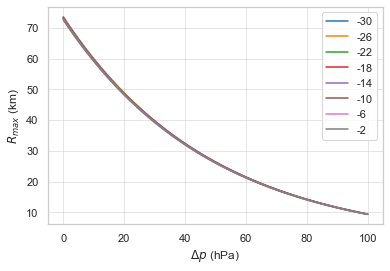

In [244]:
deltap = np.linspace(0, 100, 100)
lats = np.arange(-30, -1, 4)
#lats = np.arange(2, 31, 4)
fig, ax = plt.subplots(1,1)
sns.set_palette("RdBu", 10)
for l in lats:
    xx = np.column_stack((deltap, l*np.ones(len(deltap))))
    yy = result.eval(x=xx)
    ax.plot(deltap, np.exp(yy), label="%d"%l)
ax.set_ylabel(r"$R_{max}$ (km)")
ax.set_xlabel(r"$\Delta p$ (hPa)")
ax.legend(loc=1)

/var/folders/lw/g1x0fwqd4wjf3v9dvzzwq1m00000gn/T/ipykernel_8909/3010699801.py:13: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(dp, rmax, c='k', edgecolor='r', s=50, marker='+', label='Observations')
/var/folders/lw/g1x0fwqd4wjf3v9dvzzwq1m00000gn/T/ipykernel_8909/3010699801.py:22: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[1].scatter(lat, rmax, c='k', edgecolor='r', s=50, marker='+', label='Observations')


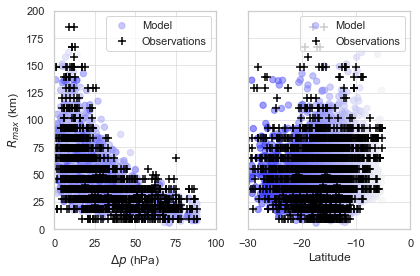

In [245]:
nx = len(dp)
ind = np.random.choice(np.arange(nx), nx, replace=True)
dp0 = dp[ind]
l0 = lat[ind]

xx = np.column_stack((dp0, l0))
yy = result.eval(x=xx) + np.random.normal(scale=0.35, size=nx)


rm = np.exp(yy)
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].scatter(dp0, rm, c=np.abs(l0), cmap=sns.light_palette('blue', as_cmap=True), s=40, label='Model', alpha=0.5)
ax[0].scatter(dp, rmax, c='k', edgecolor='r', s=50, marker='+', label='Observations')
ax[0].set_xlim(0, 100)
ax[0].set_xlabel(r"$\Delta p$ (hPa)")
ax[0].set_ylabel(r"$R_{max}$ (km)")
ax[0].set_ylim(0, 200)
ax[0].legend(loc=1)
ax[0].grid(True)

ax[1].scatter(l0, rm, c=np.abs(l0), cmap=sns.light_palette('blue', as_cmap=True), s=40, label='Model', alpha=0.5)
ax[1].scatter(lat, rmax, c='k', edgecolor='r', s=50, marker='+', label='Observations')
ax[1].set_xlim(-30, 0)
ax[1].set_xlabel(r"Latitude")
ax[1].set_ylim(0, 200)
ax[1].legend(loc=1)
ax[1].grid(True)

fig.tight_layout()

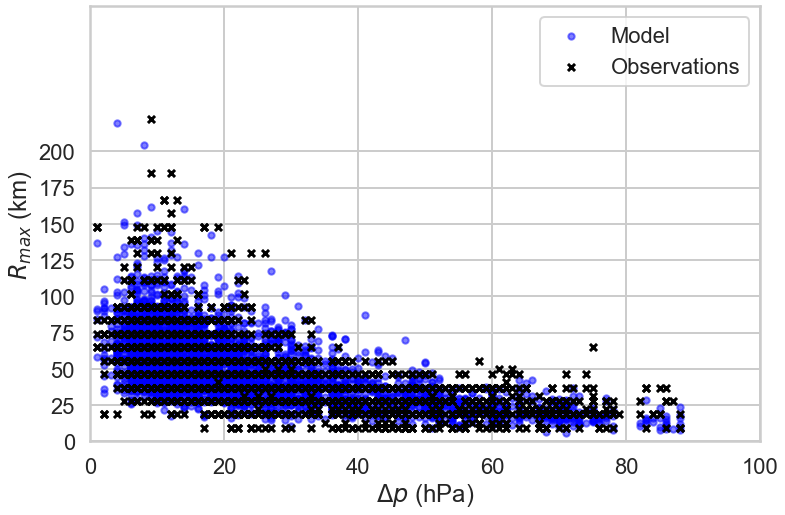

In [246]:
sns.set_context("poster")
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharey=True)
ax.scatter(dp0, rm, c='b', cmap=sns.light_palette('blue', as_cmap=True), s=40, label='Model', alpha=0.5)
ax.scatter(dp, rmax, c='k', edgecolor=None, s=50, marker='x', label='Observations')
ax.set_xlim(0, 100)
ax.set_xlabel(r"$\Delta p$ (hPa)")
ax.set_ylabel(r"$R_{max}$ (km)")
ax.set_yticks(np.arange(0,201, 25))
ax.set_ylim(0, 300)
ax.legend(loc=1)
ax.grid(True)
plt.savefig("RMax - model-obs - 2.png", bbox_inches='tight')


/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'kwargs'
  cset = contour_func(
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument

Text(80, 70, '$l_2=$0.005')

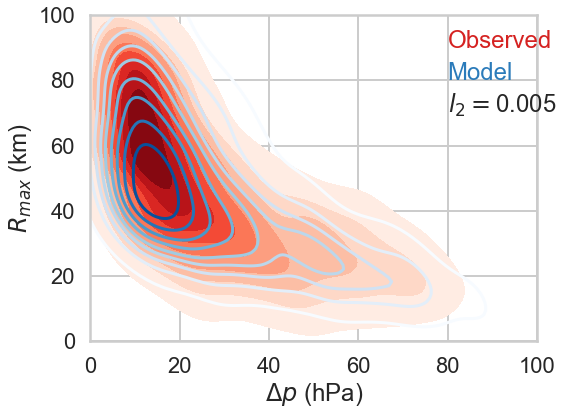

In [247]:
def bivariate_kde(x, y, bw='scott', gridsize=100, cut=3, clip=None):
    if isinstance(bw, string_types):
        bw_func = getattr(smnp.bandwidths, "bw_" + bw)
        x_bw = bw_func(x)
        y_bw = bw_func(y)
        bw = [x_bw, y_bw]
    elif np.isscalar(bw):
        bw = [bw, bw]

    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values

    kde = smnp.KDEMultivariate([x, y], "cc", bw)
    x_support = _kde_support(x, kde.bw[0], gridsize, cut, [x.min(), x.max()])# clip[0])
    y_support = _kde_support(y, kde.bw[1], gridsize, cut, [y.min(), y.max()])#clip[1])
    xx, yy = np.meshgrid(x_support, y_support)
    z = kde.pdf([xx.ravel(), yy.ravel()]).reshape(xx.shape)
    return xx, yy, z

def l2score(obs, model):
    return np.linalg.norm(obs - model, np.inf)

xx, yy, odp_rmax = bivariate_kde(dp,  rmax, bw='scott')
xx, yy, mdp_rmax = bivariate_kde(dp0.values, rm, bw='scott')

xx, yy, olat_rmax = bivariate_kde(lat,  rmax, bw='scott')
xx, yy, mlat_rmax = bivariate_kde(l0, rm, bw='scott')


l2rmdp = l2score(odp_rmax, mdp_rmax)
l2rmlat = l2score(olat_rmax, mlat_rmax)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
levs = np.arange(0.01, 0.11, 0.01)
ax = sns.kdeplot(dp, rmax, cmap='Reds', kwargs={'levels':levs}, shade=True, shade_lowest=False)
ax = sns.kdeplot(dp0.values, rm, cmap='Blues', kwargs={'levels':levs})
ax.set_xlim(0, 100)
ax.set_xlabel(r"$\Delta p$ (hPa)")
ax.set_ylabel(r"$R_{max}$ (km)")
ax.set_ylim(0, 100)
ax.grid(True)

red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(80, 90, "Observed", color=red)
ax.text(80, 80, "Model", color=blue)
ax.text(80, 70, r"$l_2=${0:.3f}".format(l2rmdp))

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'kwargs'
  cset = contour_func(
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument

Text(-5, 70, '$l_2=$0.017')

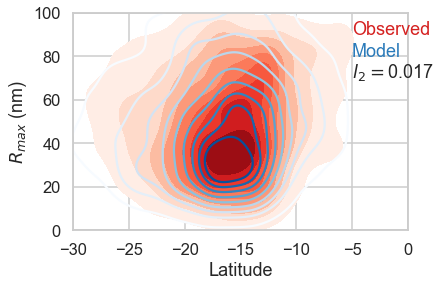

In [100]:
fig, ax = plt.subplots(1, 1)
ax = sns.kdeplot(lat, rmax, cmap='Reds', kwargs={'levels':levs}, shade=True, shade_lowest=False)
ax = sns.kdeplot(l0.values, rm, cmap='Blues', kwargs={'levels':levs})
ax.set_xlim(-30, 0)
ax.set_xlabel("Latitude")
ax.set_ylabel(r"$R_{max}$ (nm)")
ax.set_ylim(0, 100)
ax.grid(True)



ax.text(-5, 90, "Observed", color=red)
ax.text(-5, 80, "Model", color=blue)
ax.text(-5, 70, r"$l_2=${0:.3f}".format(l2rmlat))

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.025)

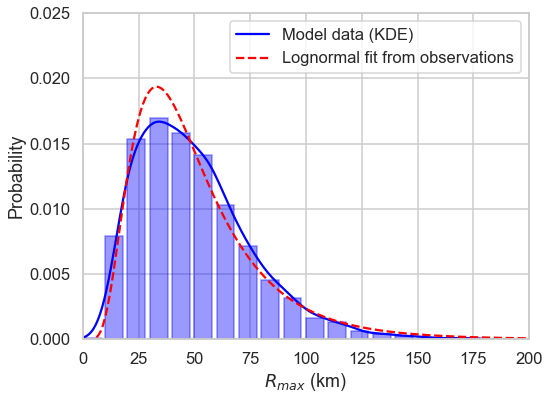

In [102]:
sns.set_style("whitegrid")
sns.set_context("talk")
x = np.arange(1, 201)
v = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.distplot(rm, bins=np.arange(0, 201, 10), color='b',
             hist_kws={'ec':'b', 'width':8},
             kde_kws={'label':"Model data (KDE)"},)
ax.plot(x, v, label="Lognormal fit from observations", color='r', linestyle='--')
ax.legend(loc=0)
ax.set_xlabel(r'$R_{max}$ (km)')
ax.set_ylabel("Probability")
ax.set_xlim((0, 200))
ax.set_ylim((0, 0.025))
# plt.savefig()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


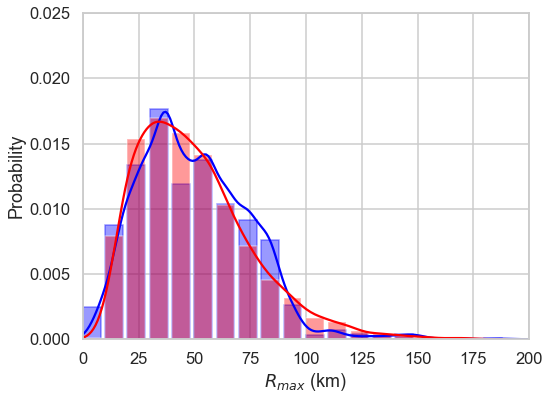

In [103]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.distplot(rmax, bins=np.arange(0, 201, 10),
             hist_kws={'ec':'b', 'width':8},
             kde_kws={'clip':(0, 200), 'label':"Observations"}, ax=ax, color='b',)
sns.distplot(rm, bins=np.arange(0, 201, 10),
             kde_kws={'clip':(0, 200), 'label':"Model"}, ax=ax, color='r',
             hist_kws={ "width":8})
ax.set_ylabel("Probability")
ax.set_xlabel(r"$R_{max}$ (km)")
ax.set_xlim((0, 200))
ax.set_ylim((0, 0.025))
plt.savefig("RMax - model-obs - distribution - 2.png", bbox_inches='tight')